In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries loaded.")


#Data loading and checking shape for basic understanding


train = pd.read_csv("D:/BTD/rossman-eda-ml/data/raw/train.csv",dtype={'StateHoliday': 'str'})
test = pd.read_csv("D:/BTD/rossman-eda-ml/data/raw/test.csv")
store = pd.read_csv("D:/BTD/rossman-eda-ml/data/raw/store.csv")

print("Files loaded.")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Store shape:", store.shape)

store.head()
train.tail()

Libraries loaded.
Files loaded.
Train shape: (1017209, 9)
Test shape: (41088, 8)
Store shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,01-01-2013,0,0,0,0,0,1
1017205,1112,2,01-01-2013,0,0,0,0,0,1
1017206,1113,2,01-01-2013,0,0,0,0,0,1
1017207,1114,2,01-01-2013,0,0,0,0,0,1
1017208,1115,2,01-01-2013,0,0,0,0,0,1


In [5]:
#Merging datasers train and test on store
train_full = train.merge(store, on='Store', how='left')
test_full = test.merge(store, on='Store', how='left')

print(f"Train shape after merge: {train_full.shape}")
print(f"New columns added: {set(train_full.columns) - set(train.columns)}")

print(f"Test shape after merge: {test_full.shape}")
print(f"New columns added: {set(test_full.columns) - set(test.columns)}")

Train shape after merge: (1017209, 18)
New columns added: {'StoreType', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'CompetitionDistance', 'Promo2', 'Assortment'}
Test shape after merge: (41088, 17)
New columns added: {'StoreType', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'CompetitionDistance', 'Promo2', 'Assortment'}


In [6]:
# Sales performance per store type
print("\n Sales by store type:")
store_performance = train_full.groupby('StoreType').agg({
    'Sales': ['mean', 'median', 'std'],
    'Customers': 'mean',
    'Store': 'nunique'
}).round(2)
print(store_performance)

# Assortment impact on sales
print("\n Sales by assortment type:")
assortment_impact = train_full.groupby('Assortment').agg({
    'Sales': ['mean', 'count'],
    'Customers': 'mean'
}).round(2)
print(assortment_impact)


 Sales by store type:
              Sales                  Customers   Store
               mean  median      std      mean nunique
StoreType                                             
a           5738.18  5618.0  3964.03    659.03     602
b          10058.84  9025.5  5280.53   1987.72      17
c           5723.63  5766.0  3721.70    673.27     148
d           5641.82  5826.0  3473.39    501.43     348

 Sales by assortment type:
              Sales         Customers
               mean   count      mean
Assortment                           
a           5481.03  537445    619.16
b           8553.93    8294   2046.36
c           6058.68  471470    624.22



 Competition Analysis:
                       Sales  Customers  Store
CompetitionCategory                           
Very Close (<500m)   6307.39     802.77    220
Close (500m-2km)     5768.29     677.53    282
Medium (2-10km)      5544.37     552.73    423
Far (>10km)          5685.55     549.77    187


C:\Users\Shahpure\AppData\Local\Temp\ipykernel_38520\1685924461.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  competition_analysis = train_full.groupby('CompetitionCategory').agg({'Sales': 'mean', 'Customers': 'mean', 'Store': 'nunique'}).round(2)


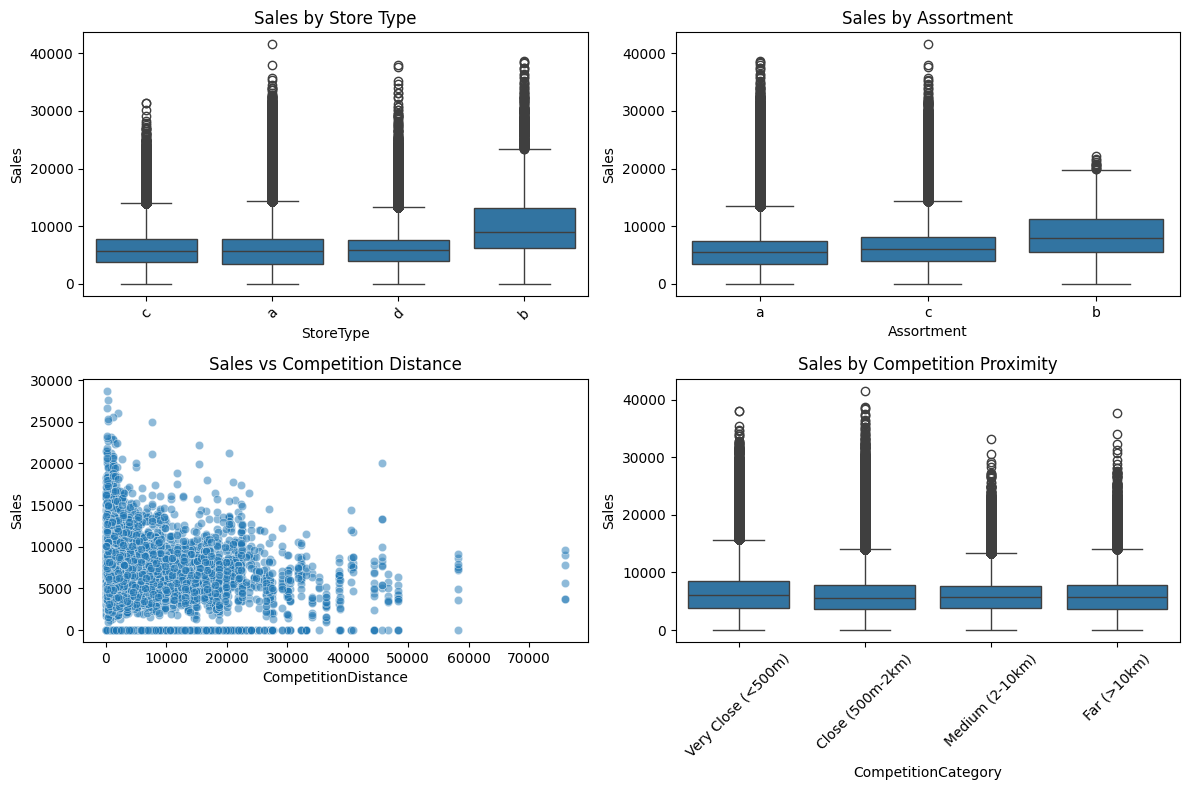

In [7]:
# Competition impact on sales
print("\n Competition Analysis:")

# Categorize competition distance
train_full['CompetitionCategory'] = pd.cut(train_full['CompetitionDistance'], bins=[0, 500, 2000, 10000, float('inf')], labels=['Very Close (<500m)', 'Close (500m-2km)', 'Medium (2-10km)', 'Far (>10km)'])

competition_analysis = train_full.groupby('CompetitionCategory').agg({'Sales': 'mean', 'Customers': 'mean', 'Store': 'nunique'}).round(2)
print(competition_analysis)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(data=train_full, x='StoreType', y='Sales')
plt.title('Sales by Store Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(data=train_full, x='Assortment', y='Sales')
plt.title('Sales by Assortment')

plt.subplot(2, 2, 3)
sns.scatterplot(data=train_full.sample(10000), x='CompetitionDistance', y='Sales', alpha=0.5)
plt.title('Sales vs Competition Distance')

plt.subplot(2, 2, 4)
sns.boxplot(data=train_full.dropna(subset=['CompetitionCategory']), 
            x='CompetitionCategory', y='Sales')
plt.title('Sales by Competition Proximity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [8]:
# Create advanced features from merged data
print("\n Advance feature engineering:")

# Store age (how long competition has been open)
train_full['CompetitionAge'] = (pd.to_datetime(train_full['Date']).dt.year - train_full['CompetitionOpenSinceYear'])

# Sales per customer ratio
train_full['SalesPerCustomer'] = train_full['Sales'] / (train_full['Customers'] + 1)

# Store performance relative to store type average
store_type_avg = train_full.groupby('StoreType')['Sales'].transform('mean')
train_full['RelativePerformance'] = train_full['Sales'] / store_type_avg

# Monthly seasonality within store
train_full['Month'] = pd.to_datetime(train_full['Date']).dt.month
train_full['StoreMonthAvg'] = train_full.groupby(['Store', 'Month'])['Sales'].transform('mean')

print("New features created:")
new_features = ['CompetitionAge', 'SalesPerCustomer', 'RelativePerformance', 'StoreMonthAvg']
for feature in new_features:
    print(f"{feature}: {train_full[feature].describe().round(2).to_dict()}")


 Advance feature engineering:


C:\Users\Shahpure\AppData\Local\Temp\ipykernel_38520\4037834146.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_full['CompetitionAge'] = (pd.to_datetime(train_full['Date']).dt.year - train_full['CompetitionOpenSinceYear'])
C:\Users\Shahpure\AppData\Local\Temp\ipykernel_38520\4037834146.py:15: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_full['Month'] = pd.to_datetime(train_full['Date']).dt.month


New features created:
CompetitionAge: {'count': 693861.0, 'mean': 5.14, 'std': 6.04, 'min': -2.0, '25%': 1.0, '50%': 4.0, '75%': 8.0, 'max': 115.0}
SalesPerCustomer: {'count': 1017209.0, 'mean': 7.87, 'std': 4.08, 'min': 0.0, '25%': 6.9, '50%': 8.67, '75%': 10.49, 'max': 64.71}
RelativePerformance: {'count': 1017209.0, 'mean': 1.0, 'std': 0.66, 'min': 0.0, '25%': 0.65, '50%': 1.0, '75%': 1.37, 'max': 7.24}
StoreMonthAvg: {'count': 1017209.0, 'mean': 5773.82, 'std': 2099.36, 'min': 1446.15, '25%': 4389.07, '50%': 5449.78, '75%': 6660.39, 'max': 24320.97}


In [10]:
# Promo2 effectiveness
print("\n Promo2 Analysis:")
promo2_analysis = train_full.groupby('Promo2').agg({
    'Sales': ['mean', 'std'],
    'Customers': 'mean',
    'Store': 'nunique'
}).round(2)
print(promo2_analysis)

# Combined promo effect (Promo + Promo2)
train_full['PromoCombo'] = train_full['Promo'].astype(str) + '_' + train_full['Promo2'].astype(str)
combo_effect = train_full.groupby('PromoCombo')['Sales'].mean().round(2)
print("\n Combo Effect:")
print(combo_effect)


 Promo2 Analysis:
          Sales          Customers   Store
           mean      std      mean nunique
Promo2                                    
0       6124.71  4136.14    702.96     544
1       5423.72  3506.56    563.49     571

 Combo Effect:
PromoCombo
0_0    4722.19
0_1    4091.11
1_0    8393.78
1_1    7588.42
Name: Sales, dtype: float64


In [11]:
def generate_enhanced_insights():
    """Enhanced business insights with store characteristics"""
    
    insights = {
        'Store Portfolio Analysis': {
            'Total Stores': train_full['Store'].nunique(),'Best Store Type (Avg Sales)': train_full.groupby('StoreType')['Sales'].mean().idxmax(),'Best Assortment Level': train_full.groupby('Assortment')['Sales'].mean().idxmax(),'Stores with Competition <1km': len(train_full[train_full['CompetitionDistance'] < 1000]['Store'].unique())
        },
        'Competition Impact': {
            'High Competition Sales': train_full[train_full['CompetitionDistance'] < 1000]['Sales'].mean(), 'Low Competition Sales': train_full[train_full['CompetitionDistance'] > 5000]['Sales'].mean(), 'Competition Effect': f"{((train_full[train_full['CompetitionDistance'] > 5000]['Sales'].mean() / train_full[train_full['CompetitionDistance'] < 1000]['Sales'].mean() - 1) * 100):.1f}%"
        },
        'Promotion Strategy': {
            'Promo1 Effect': f"{((train_full[train_full['Promo']==1]['Sales'].mean() / train_full[train_full['Promo']==0]['Sales'].mean() - 1) * 100):.1f}%", 'Promo2 Effect': f"{((train_full[train_full['Promo2']==1]['Sales'].mean() / train_full[train_full['Promo2']==0]['Sales'].mean() - 1) * 100):.1f}%",'Best Promo Combo': train_full.groupby('PromoCombo')['Sales'].mean().idxmax()
        }
    }
    
    print("\n Enhanced business insights like best perofrming store and stuff")
    print("=" * 60)
    for category, metrics in insights.items():
        print(f"\n {category}:")
        for key, value in metrics.items():
            print(f"{key}: {value}")

generate_enhanced_insights()


 Enhanced business insights like best perofrming store and stuff

 Store Portfolio Analysis:
Total Stores: 1115
Best Store Type (Avg Sales): b
Best Assortment Level: b
Stores with Competition <1km: 328

 Competition Impact:
High Competition Sales: 6070.139244889737
Low Competition Sales: 5630.9841322117045
Competition Effect: -7.2%

 Promotion Strategy:
Promo1 Effect: 81.4%
Promo2 Effect: -11.4%
Best Promo Combo: 1_0
